---
author: Timothy Oliver
format:
    html:
        toc: true
        page-layout: full
        code-fold:  true
execute:
    warning:    false
    message:    false
---

In [82]:
import nltk
import string
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import altair as alt
# import copy
# import math

# later cluster analysis
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler

In [83]:
# df = copy.copy(zillow)
# nhoodList=nhoods
def getNHood_or_Count(df,searchL,switchCol="neighborhood"):
    nlist = []
    prev = 0

    for i in range(len(df)):
        prev = len(nlist)
        sum=0
        descText = df[i:i+1]["description"].squeeze()
        desc = descText.split(" ")
            
        if switchCol == "neighborhood":
            for nhood in searchL:     # any(set(nhood).issubset(descText) 
                    if nhood in descText:
                        nlist.append(nhood)
                        break
            if len(nlist) == prev:
                nlist.append("")
        else:
            for nhood in searchL:     # any(set(nhood).issubset(descText) 
                if nhood in descText:
                    sum+=1
                        
            nlist.append(sum)
    



    df[switchCol] = nlist
    return df

    


In [84]:
def getAmenityTitles(df,col="title"):
    k = list(df[col])
    # print(k)
    ind = []
    mul = []
    for elem in range(len(k)):
        k[elem] = k[elem].lower()
        if len(k[elem].split(", "))>1:
            ind.append(elem)

    for l in range(len(ind)):
        mul.append(k[ind[l]])

    ind.reverse()
    for l in range(len(ind)):
        del k[ind[l]]

    for m in mul:
        # print(m.split(", "))
        k.extend(m.split(", "))

    # print(k[-1])
    k.reverse()
    # print(k[-1])

    # print(len(k))
    # get unique values in k
    k = list(set(k))
    # print(len(k))
    return k




# Zillow Description Cross-Reference

## Gathering Neighborhood and Amenity Mentions

Using the created data from the Yelp API and webscraped Zillow listing descriptions, we are quickly able to organize the relative locations and highly regarded amenities of the property listed. The neighborhood designation offers a reasonable alternative to geocoding when the listing title does not have an address. The results of this data cleaning (with the exception of geocoding) is viewable for the first 8 records below.

From the different individual descriptors of Yelp amenity groups, we can associate an approximate measure of importance of the category from the words the realtor chose. Ideally, these added counts will make a referencable cluster analysis of Philadelphia neighborhoods possible to compare with aggregated point data and ratings from Yelp.

In [85]:
# input = "../webscraping_outputs-Z/clean/ZillowUnique.csv"
input = "../data/webscraping_outputs-Z/clean/ZillowUnique_v1.csv"
try:
    zillowFull = pd.read_csv(input)
except FileNotFoundError:
    zillowFull = pd.read_csv("../data/webscraping_outputs-Z/best_pre_neighborhood/ZillowSelenium_2023_Dec_10_19-09-38")

# handle nans
zillow = zillowFull.drop(zillowFull.loc[zillowFull["description"].isna()].index) # can choose to fill them too, but better for frequencies

# get philly neighborhoods and amenities too
phl_nhoods = gpd.read_file("https://raw.githubusercontent.com/opendataphilly/open-geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson")
phl_bound = gpd.read_file("../data/Yelp API/phl_bound.geojson").to_crs(2272)
restaurant = getAmenityTitles(gpd.read_file("../data/Yelp API/restaurants.geojson"))
park = getAmenityTitles(gpd.read_file("../data/Yelp API/parks.geojson"))
edu = getAmenityTitles(gpd.read_file("../data/Yelp API/education.geojson"))
grocery = getAmenityTitles(gpd.read_file("../data/Yelp API/grocery.geojson"))
entertainment = getAmenityTitles(gpd.read_file("../data/Yelp API/entertainment.geojson"))
nightlife = getAmenityTitles(gpd.read_file("../data/Yelp API/nightlife.geojson"))
shopping = getAmenityTitles(gpd.read_file("../data/Yelp API/shopping.geojson"))
healthcare = getAmenityTitles(gpd.read_file("../data/Yelp API/healthcare.geojson"))
historic = getAmenityTitles(gpd.read_file("../data/Yelp API/historic_landmarks.geojson"))
kids = getAmenityTitles(gpd.read_file("../data/Yelp API/kids.geojson"))
arts = getAmenityTitles(gpd.read_file("../data/Yelp API/perf_arts.geojson"))
beauty = getAmenityTitles(gpd.read_file("../data/Yelp API/beauty.geojson"))

# master amenity list
amenity_list = restaurant.copy()
for amenL in [park,edu,grocery,entertainment,nightlife,shopping,healthcare,historic,kids,arts,beauty]:
    amenity_list.extend(amenL)

amenity_types = 12

nhoods = list(phl_nhoods["listname"])

toAdd = []
for n in nhoods:
    if len(n.split("-")) > 1:
        toAdd.append(n.split("-")[0].strip())
    if len(n.split(",")) > 1:
        toAdd.append(n.split(",")[0].strip())

nhoods.extend(toAdd)

zillow = df=getNHood_or_Count(switchCol="beauty",searchL=beauty,
                              df=getNHood_or_Count(switchCol="arts",searchL=arts,
                                df=getNHood_or_Count(switchCol="kids",searchL=kids,
                                    df=getNHood_or_Count(switchCol="historic",searchL=historic,
                                        df=getNHood_or_Count(switchCol="healthcare",searchL=healthcare,
                                            df=getNHood_or_Count(switchCol="shopping",searchL=shopping,
                                                df=getNHood_or_Count(switchCol="nightlife",searchL=nightlife,
                                                    df=getNHood_or_Count(switchCol="entertainment",searchL=entertainment,
                                                        df=getNHood_or_Count(switchCol="grocery",searchL=grocery,
                                                            df=getNHood_or_Count(switchCol="education",searchL=edu,
                                                                df=getNHood_or_Count(switchCol="parks",searchL=park,
                                                                    df=getNHood_or_Count(switchCol="restaurants",searchL=restaurant,
                                                                        df=getNHood_or_Count(zillow,nhoods)))))))))))))

zillow.head(8)



,title,description,url,neighborhood,restaurants,parks,education,grocery,entertainment,nightlife,shopping,healthcare,historic,kids,arts,beauty
0,The Legacy at Powelton Village,Our University City student apartments are des...,https://www.zillow.com/apartments/philadelphia...,Powelton,1,0,1,0,1,0,1,1,0,2,0,2
1,The Piazza,A vibrant hub centered in the fashionable dist...,https://www.zillow.com/apartments/philadelphia...,Northern Liberties,1,0,1,0,1,0,1,1,0,2,0,2
2,"The Aster, 4550 Mitchell St, Philadelphia, PA ...","The building has a variety of studio, 1, 2, an...",https://www.zillow.com/homedetails/4550-Mitche...,,1,0,1,0,2,0,2,1,0,2,0,3
3,The Latham at Seventeenth,"Located just one block to Rittenhouse Square, ...",https://www.zillow.com/apartments/philadelphia...,Rittenhouse,1,0,1,0,1,0,0,1,0,1,0,1
4,The Irvine - Modern Luxury Apartments In Spruc...,"Recycled, Renovated, & Reimagined. The Irvine ...",https://www.zillow.com/apartments/philadelphia...,,2,2,1,0,3,3,1,1,0,4,0,2
5,1600 Chestnut Apartments,1600 Chestnut is the perfect residence for tho...,https://www.zillow.com/apartments/philadelphia...,,2,0,1,0,2,1,1,1,0,3,0,2
6,"1327 N Marston, 1327 N Marston St, Philadelphi...","Welcome to The Milk Depot! Modern, new-constru...",https://www.zillow.com/homedetails/1327-N-Mars...,Brewerytown,1,0,1,0,1,0,1,1,0,2,0,2
7,1327 N Marston,"Welcome to The Milk Depot! Modern, new-constru...",https://www.zillow.com/apartments/philadelphia...,Brewerytown,1,0,1,0,1,0,1,1,0,2,0,2


In [ ]:
#|  eval:   false
#|  echo:   false
# test if there are any "" or NaN in description
for i in range(len(zillow["description"])):
    t = zillow["description"][i:i+1].squeeze()
    print(type(t))
    if type(t)!=type("help"): #"<class 'str'>"
        print(t)

In [ ]:
#|  results:   false
punc = list(string.punctuation)
nltk.download("stopwords");
stop_words = list(set(nltk.corpus.stopwords.words("english")))

desc = zillow["description"].str.strip().tolist()
desc[:3]

words = [d.split() for d in desc]

flat_w = []
for wList in words:
    for w in wList:
        if w[-1] in string.punctuation:
            w = w[:-1]
        flat_w.append(w.lower())

no_stop = [w for w in flat_w if (w not in stop_words) and (w not in punc)]

# now for neighborhoods
neighborhoods = [d for d in zillow["neighborhood"]]

no_stop_nhoods = [w for w in neighborhoods if (w not in stop_words) and (w not in punc)]

words = pd.DataFrame({"words": no_stop}).groupby("words",as_index=False).size().sort_values("size",ascending=False,ignore_index=True)
words = words.loc[words["words"].isin(amenity_list)]
words = words.drop(words.loc[words["words"]==""].index)

nhoodFreq = pd.DataFrame({"neighborhood": no_stop_nhoods}).groupby("neighborhood",as_index=False).size().sort_values("size",ascending=False,ignore_index=True)
nhoodFreq.drop(nhoodFreq.loc[nhoodFreq["neighborhood"]==""].index,inplace=True)


## display the words dataframe if you wish
# words.head(15)

In [88]:
#|  eval:   false
## save files for easy import across notebooks

words.to_csv("../data/cleaned_for_notebooks/words.csv", index = False)
nhoodFreq.to_csv("../data/cleaned_for_notebooks/frequent_neighborhood1.csv", index = False)
zillow.to_csv("../data/cleaned_for_notebooks/zillow_mentions.csv", index = False)

In [ ]:
#|  eval:   false

'''
If additional words should be removed, create a list here
'''

to_remove = ["home","room","kitchen","property","floor","bedrooms","bedroom","rooms",""]

words = words.drop(index = words.loc[words["words"].isin(to_remove)].index)

print(words.head(25))
# and save to csv if desired

# words.to_csv("../words.csv", index = False)


## **Amenity Wordcloud from Zillow Listing Descriptions**

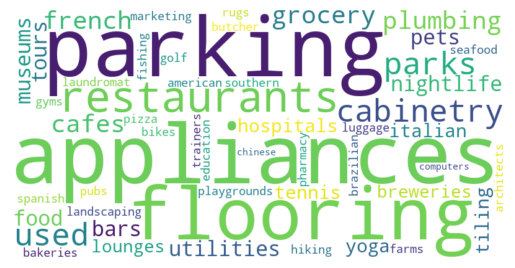

In [90]:
text = ' '.join(words["words"])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud using matplotlib


# Format
fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
plt.show()
# plt.savefig(fname="../images/zillow_amenity_word_cloud.jpg",pad_inches=2,dpi=150)

From this word cloud, it is quickly apparent that words that might be related not only to houses, but also housing good stores like 'appliances' are relatively common. These add some specific consideration for words to be put in a user-defined removal list in future word frequency explorations and visualizations like bar charts of specific words. Otherwise, restaurants is the most common followed by similar food related words like 'grocery' and 'french' suggesting that restaurants are the most common amenity type. This is supported by our exploratory analysis of Yelp data. 

Given the unique association to a business type, the counts of these words do not appear especially problematic for cluster analysis and listing counts. Though major differences in group representation can help clarify.

## **Neighborhood Wordcloud from Zillow Listing Descriptions**

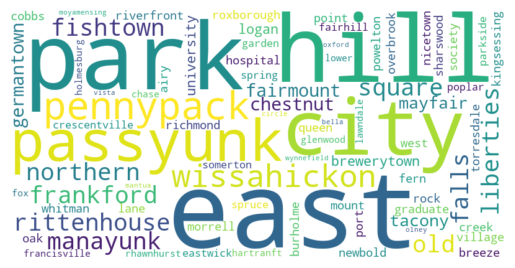

In [91]:
text = ' '.join(nhoodFreq["neighborhood"]).lower()

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud using matplotlib


# Format
fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
plt.show()
# plt.savefig(fname="../images/zillow_neighborhood_word_cloud.jpg",pad_inches=2,dpi=150)

This word cloud gives a quick glance of the most often mentioned neighborhoods in the Zillow listings. There are unfortunately problems in accounting for words where the neighborhood name is split and the presence of common words like park, east, and hill (18, 12, & 8 neighborhoods include those words in their names, respectively). However, we can see that 'city' neighborhoods (i.e., Center City, University City, and Old City), PennyPack, Wissahickon, and other specific neighborhoods are relatively common. In consideration of amenity clusters, future geocoding of the location and cluster analysis of the amenity frequencies will likely provide clearer pictures of the businesses and services near those homes while others will not have as reliable profiles using Zillow alone.


<br></br>It is important to note that the listings change often, and that results depicted here will not be the same as those reproduced. 
<br></br>The data used to create this word cloud comes from 20 webpages of listings from December 10, 2023 at 07:09:38 PM.

In [ ]:
#| eval: false
for n in nhoods:
    if "park" in n.lower():
        print(n)

print("\n\n")

for n in nhoods:
    if "east" in n.lower():
        print(n)

print("\n\n")

for n in nhoods:
    if "city" in n.lower():
        print(n)

## **Sample Cluster Analysis of Neighborhood Amenity Typologies**

In [ ]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)

nhAmenity_scored = zillow.groupby("neighborhood",as_index=False).sum()
nhAmenity_scored = nhAmenity_scored.drop(nhAmenity_scored.loc[nhAmenity_scored["neighborhood"]==""].index)

phl_nhoods = phl_nhoods.rename(columns={"listname":"neighborhood"}).merge(nhAmenity_scored,on="neighborhood")
del(nhAmenity_scored)

amenity_cols = ["restaurants","parks","education","grocery","entertainment","nightlife","shopping","healthcare","historic","kids","arts","beauty"]
amenity_mention_scaled = scaler.fit_transform(phl_nhoods[amenity_cols])
kmeans.fit(amenity_mention_scaled)

# Extract the labels
phl_nhoods['label'] = kmeans.labels_


In [ ]:
#| eval: false
cluster_size = phl_nhoods.groupby("label").size()
cluster_size

rest_size = phl_nhoods.groupby("label")["restaurants"].mean()
rest_size

Using the amenity mention counts and neighborhood assignments obtained earlier, we organize a simple 6 cluster analysis similar to that general amenity cluster shown in `Exploratory Analysis` based on the amenity mention counts.

In [103]:
## Proportional Scatter Plot
(
    alt.Chart(phl_nhoods)
    .mark_circle()
    .encode(
        alt.X("restaurants:Q", scale=alt.Scale(type="log")),
        alt.Y("shape_area:Q", scale=alt.Scale(zero=False)),
        size="restaurants:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(phl_nhoods.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

C:\Users\timol\AppData\Roaming\Python\Python310\site-packages\altair\utils\core.py:230: UserWarning: I don't know how to infer vegalite type from 'unknown-array'.  Defaulting to nominal.
  warnings.warn(


alt.Chart(...)

This graph shows no immediate relationship between the clusters and individual amenity counts or geographic features like the square mile area of the neighborhood. Slight determination of cluster by the number of restaurant mentions is possible, and exceptions can likely be explained by other largely contributing amenity types.

In [101]:
# Calculate the mean values of the amenities
mean_values = phl_nhoods.groupby("label",as_index=False)[["arts", "beauty", "education", "entertainment", "grocery", "healthcare", "historic", "kids", "nightlife", "parks", "restaurants", "shopping"]].mean().round(0)

# Calculate the counts for each cluster
counts = phl_nhoods['label'].value_counts().rename_axis('label').reset_index(name='neighborhoods')

# Merge the mean values and counts into one DataFrame
cluster_profile = pd.merge(mean_values, counts, on='label').reset_index()

# Display the merged DataFrame
cluster_profile = cluster_profile.rename(columns={"index":"cluster"})
cluster_profile["cluster"]=["15 mentions : 35 Neighborhoods","40 mentions : 3 Neighborhoods","125 mentions : 4 Neighborhoods","48 mentions : 11 Neighborhoods","229 mentions : 1 Neighborhood","72 mentions : 5 Neighborhoods","86 mentions : 1 Neighborhood"]
cluster_profile

,cluster,label,arts,beauty,education,entertainment,grocery,healthcare,historic,kids,nightlife,parks,restaurants,shopping,neighborhoods
0,15 mentions : 35 Neighborhoods,0,0.0,3.0,1.0,3.0,0.0,1.0,0.0,3.0,1.0,0.0,2.0,1.0,35
1,40 mentions : 3 Neighborhoods,1,1.0,5.0,4.0,7.0,0.0,3.0,1.0,6.0,3.0,2.0,5.0,3.0,3
2,125 mentions : 4 Neighborhoods,2,0.0,25.0,12.0,25.0,1.0,12.0,0.0,25.0,9.0,2.0,20.0,13.0,4
3,48 mentions : 11 Neighborhoods,3,0.0,9.0,4.0,8.0,1.0,4.0,0.0,9.0,2.0,0.0,6.0,5.0,11
4,229 mentions : 1 Neighborhood,4,2.0,47.0,18.0,35.0,4.0,20.0,0.0,38.0,9.0,2.0,27.0,27.0,1
5,72 mentions : 5 Neighborhoods,5,1.0,11.0,5.0,12.0,2.0,5.0,0.0,14.0,4.0,3.0,9.0,6.0,5
6,86 mentions : 1 Neighborhood,6,2.0,11.0,8.0,14.0,3.0,6.0,1.0,15.0,4.0,6.0,11.0,5.0,1


This dataframe of mean amenity type mentions makes it clear that Zillow descriptions (at least at the time of retrieval) are heavily skewed towards mention of nearby businesses and services for kids, education, restaurants, and shopping while also raising the question of arts and beautry mentions truly being in reference to the areas around a property or for the property itself.

A few neighborhoods like that in clusters 4 and 6 have many more mentions of amenities than those elsewhere with the following map identifying cluster 4's neighborhood as Frankford. There is difficulty in telling if given neighborhoods are more descriptive due to higher house price or the number of businesses, but the comparison of individual point data or Yelp clusters needs more integration to be viable.

In [102]:
## Map of Clusters
phl_nhoods.drop(columns=["updated_at","created_at"]).explore(
    column="label",
    cmap="Set2",
    categorical=True,
    tiles="CartoDB positron"
)


This map of the neighborhoods by cluster group highlights the high number of neighborhoods missing from the description alone, but also shows the difficulty in differentiating the somewhat similar ratio of amenity types in the mean number in each cluster. More granularity would serve this analysis well which geocoding should be a potential solution to.